In [1]:
import numpy as np
import pandas as pd
import pickle

import tensorflow as tf
import math
import json

from sklearn.model_selection import *
from sklearn import metrics

from daf.datasets import atti_dataset
from daf.utils import dataset_utils
from daf.utils import keras_util

import random

/home/fabio/miniconda3/envs/dl/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Baseline Model

In [2]:
(x_train, y_train), (x_test, y_test) = atti_dataset.load_data(num_words=None)

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of d6eaee8bd106697b93982053ec65aad1 so we will re-download the data.
5537792/5535226 [==============================] - 1s 0us/step


In [4]:
label_index_dict = atti_dataset.get_label_index()

Add one because the array is zero based

In [5]:
num_words = max([max(x) for x in x_train]) + 1
num_words

52396

In [6]:
print('Total of {} classes'.format(len(label_index_dict)))
label_index_dict

Total of 34 classes


{'ALTRI UFFICI': 0,
 'AVVOCATURA REGIONALE                                  ': 1,
 'D.G.  AVVOCATURA                                      ': 2,
 "D.G. COMPETITIVITA' DEL SISTEMA REGIONALE E SVILUPPO D": 3,
 'D.G. PRESIDENZA                                       ': 4,
 'DIPARTIMENTO BILANCIO E FINANZE                       ': 5,
 'DIPARTIMENTO ORGANIZZAZIONE                           ': 6,
 'DIPARTIMENTO ORGANIZZAZIONE E RISORSE                 ': 7,
 'DIPARTIMENTO POLITICHE FORMATIVE E BENI CULTURALI     ': 8,
 'DIPARTIMENTO POLITICHE TERRITORIALI E AMBIENTALI      ': 9,
 'DIPARTIMENTO PRESIDENZA AFFARI LEGISLATIVI E GIURIDICI': 10,
 'DIPARTIMENTO SALUTE E POLITICHE SOLIDARIETA           ': 11,
 'DIPARTIMENTO SVILUPPO ECONOMICO                       ': 12,
 'DIREZIONE AFFARI LEGISLATIVI, GIURIDICI ED ISTITUZIONALI': 13,
 'DIREZIONE AGRICOLTURA E SVILUPPO RURALE': 14,
 "DIREZIONE ATTIVITA' PRODUTTIVE": 15,
 'DIREZIONE CULTURA E RICERCA': 16,
 'DIREZIONE DIFESA DEL SUOLO E PROTEZIONE CIV

## Data Preparation

create the function to trasnform the x data

In [7]:
from functools import partial

def x_transformer(x_data):
    return partial(dataset_utils.vectorize_sequences, x_data, num_words)

def y_tranformer(y_data):
    return partial(dataset_utils.to_one_hot, y_data, num_classes)

In [8]:
batch_size = 128
num_classes = len(set(y_train))
train_val_split = math.ceil(len(x_train) * 0.8)
print('num classes {}'.format(num_classes))
print('training size {}, validation size {}'.format(train_val_split, len(x_train) - train_val_split))

num classes 34
training size 117777, validation size 29444


Create the iterator for the training and validaton set

In [9]:
train_steps = train_val_split // batch_size + 1
val_steps = (len(x_train) - train_val_split) // batch_size + 1

train_generator = dataset_utils.dataset_generator_fun(x_train, y_train, x_transformer, y_tranformer, 
                                                      batch_size, 0, train_val_split, True)

val_generator = dataset_utils.dataset_generator_fun(x_train, y_train, x_transformer, y_tranformer,
                                                    batch_size, train_val_split, len(x_train), False)

In [10]:
def build_model(neurons, num_words, num_classes):
    keras_util.new_session()
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(neurons, activation='relu', input_shape=(num_words, )))
    model.add(tf.keras.layers.Dense(neurons, activation='relu'))
    model.add(tf.keras.layers.Dense(neurons, activation='relu'))
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

### Evaluate the Classifier on the following architectures

In [34]:
neurons_size = [2**x for x in range(5,10)]
neurons_size

[32, 64, 128, 256, 512]

In [47]:
def train(neurons_size, epochs):
    histories = {}
    for neuron in neurons_size:
        print('*** Network with {} ***'.format(neuron))
        model = build_model(neuron, num_words, num_classes)
        print(model.summary())
        
        callbacks = [
            tf.keras.callbacks.TensorBoard(log_dir="logs/dense_{}".format(neuron)),
            tf.keras.callbacks.EarlyStopping(patience=3, verbose=1),
            tf.keras.callbacks.ReduceLROnPlateau(patience=3)
                    ]  
        
        history = model.fit_generator(train_generator, steps_per_epoch=train_steps, epochs=epochs, 
                              validation_data=val_generator, validation_steps=val_steps, callbacks=callbacks)
        
        histories[str(neuron)] = history

Define the number of steps per epochs

In [48]:
!rm -rf logs/*

In [49]:
histories = train(neurons_size, 10)

*** Network with 32 ***
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                1676704   
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 34)                1122      
Total params: 1,679,938
Trainable params: 1,679,938
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
921/921 [==============================] - 33s 36ms/step - loss: 1.4344 - acc: 0.5824 - val_loss: 1.1088 - val_acc: 0.6486
Epoch 2/10
921/921 [==============================] - 33s 36ms/step - loss: 0.7666 - acc: 0.7541 - va

## Build the final model

the best model is obtained with 512 neurons and 3 epochs

In [11]:
train_steps = len(x_train) // batch_size + 1

train_generator = dataset_utils.dataset_generator_fun(x_train, y_train, x_transformer, y_tranformer, 
                                                      batch_size, 0, len(x_train), True)

In [12]:
model = build_model(512, num_words, num_classes)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               26827264  
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_4 (Dense)              (None, 34)                17442     
Total params: 27,370,018
Trainable params: 27,370,018
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = model.fit_generator(train_generator, train_steps, 3)

Epoch 1/3
1151/1151 [==============================] - 77s 67ms/step - loss: 0.9231 - acc: 0.7061
Epoch 2/3
1151/1151 [==============================] - 77s 67ms/step - loss: 0.4421 - acc: 0.8537
Epoch 3/3
1151/1151 [==============================] - 77s 67ms/step - loss: 0.2926 - acc: 0.9035


## Evaluate on the test set

In [24]:
x_test_v = dataset_utils.vectorize_sequences(x_test, num_words)
y_test_v = dataset_utils.to_one_hot(y_test, num_classes)

(36806, 52396)

In [26]:
test_predictions = model.predict(x_test_v, verbose=1)

36806/36806 [==============================] - 6s 159us/step


In [35]:
predictions = np.array([np.argmax(x) for x in test_predictions])
precision, recall, fscore, _ = metrics.precision_recall_fscore_support(y_test,predictions, average='weighted')
accuracy = metrics.accuracy_score(y_test, predictions)

auc_score = metrics.roc_auc_score(y_test_v, test_predictions, average='weighted')

print('accuracy ', accuracy)
print('precision ', precision)
print('recall ', recall)
print('f-measure ', fscore)

accuracy  0.7580557517796012
precision  0.7618872778774636
recall  0.7580557517796012
f-measure  0.7577387453240897


### Report the classification result for each class

In [36]:
print(metrics.classification_report(y_test, predictions))

             precision    recall  f1-score   support

          0       0.53      0.56      0.54       212
          1       0.61      0.45      0.52       228
          2       0.83      0.88      0.85       718
          3       0.67      0.80      0.73      3150
          4       0.76      0.73      0.75      2488
          5       0.76      0.47      0.58       306
          6       0.61      0.55      0.58       651
          7       0.41      0.52      0.46       350
          8       0.69      0.69      0.69       771
          9       0.82      0.69      0.75      1759
         10       0.73      0.62      0.67       777
         11       0.70      0.63      0.66      1037
         12       0.73      0.68      0.70      1177
         13       0.51      0.55      0.53       175
         14       0.97      0.92      0.94      2812
         15       0.74      0.68      0.71       432
         16       0.76      0.47      0.58       194
         17       0.94      0.93      0.93   

### Confusion Matrix

In [37]:
conf_matrix = metrics.confusion_matrix(y_test, predictions)

In [38]:
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
np.set_printoptions(precision=2)

Confusion matrix, without normalization


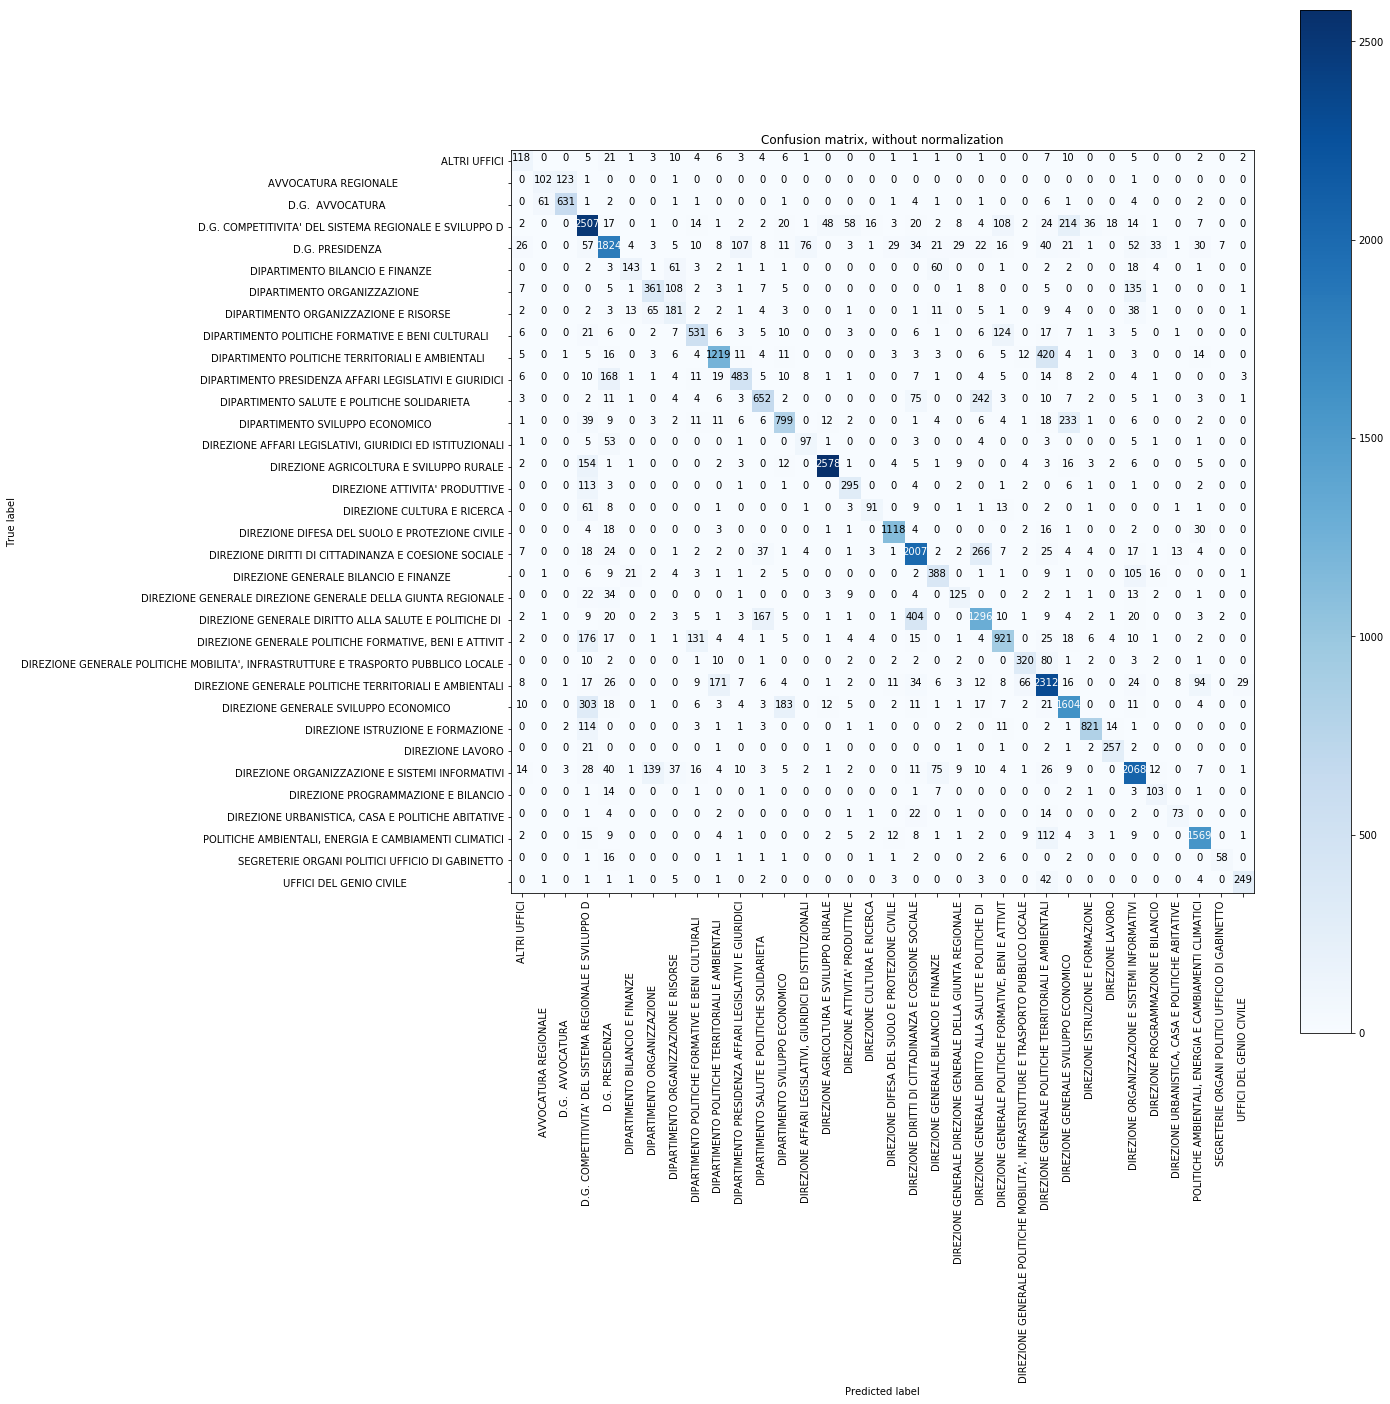

In [39]:
plt.rcParams['figure.figsize'] = (20,20)
plot_confusion_matrix(conf_matrix, classes=label_index_dict,
                      title='Confusion matrix, without normalization')